## House Prices Prediction

In this tutorial we will prepare a dataset with houses characteristics and selling prices and train a regression model for sales price prediction.

The dataset to be used is the [Ames Housing Dataset](https://www.openintro.org/stat/data/?data=ames), which has variables describing (almost) every aspect of residential homes in Ames, Iowa.

A detailed description of the variables in this dataset can be found [here](http://jse.amstat.org/v19n3/decock/DataDocumentation.txt).

We begin by importing the necessary packages and setting some notebook options.

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

warnings.filterwarnings('ignore')

%matplotlib inline

pd.options.display.max_rows = None
pd.options.display.max_columns = None

Here we download the dataset described above.

In [2]:
data_folder = "./data"
os.makedirs(data_folder, exist_ok=True)

!wget https://www.openintro.org/stat/data/ames.csv -O ./data/ames.csv

'wget' is not recognized as an internal or external command,
operable program or batch file.


We then load the dataset into a Pandas data frame, visualize the first 10 rows, and print the total number of rows and columns. We notice that this dataset has 2930 rows and 82 columns. Our response variable is the column named "SalePrice".

In [3]:
df_housing = pd.read_csv("./data/ames.csv")

df_housing.head(10)

,Order,PID,MS.SubClass,MS.Zoning,Lot.Frontage,Lot.Area,Street,Alley,Lot.Shape,Land.Contour,Utilities,Lot.Config,Land.Slope,Neighborhood,Condition.1,Condition.2,Bldg.Type,House.Style,Overall.Qual,Overall.Cond,Year.Built,Year.Remod.Add,Roof.Style,Roof.Matl,Exterior.1st,Exterior.2nd,Mas.Vnr.Type,Mas.Vnr.Area,Exter.Qual,Exter.Cond,Foundation,Bsmt.Qual,Bsmt.Cond,Bsmt.Exposure,BsmtFin.Type.1,BsmtFin.SF.1,BsmtFin.Type.2,BsmtFin.SF.2,Bsmt.Unf.SF,Total.Bsmt.SF,Heating,Heating.QC,Central.Air,Electrical,X1st.Flr.SF,X2nd.Flr.SF,Low.Qual.Fin.SF,Gr.Liv.Area,Bsmt.Full.Bath,Bsmt.Half.Bath,Full.Bath,Half.Bath,Bedroom.AbvGr,Kitchen.AbvGr,Kitchen.Qual,TotRms.AbvGrd,Functional,Fireplaces,Fireplace.Qu,Garage.Type,Garage.Yr.Blt,Garage.Finish,Garage.Cars,Garage.Area,Garage.Qual,Garage.Cond,Paved.Drive,Wood.Deck.SF,Open.Porch.SF,Enclosed.Porch,X3Ssn.Porch,Screen.Porch,Pool.Area,Pool.QC,Fence,Misc.Feature,Misc.Val,Mo.Sold,Yr.Sold,Sale.Type,Sale.Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,5,1960,1960,Hip,CompShg,BrkFace,Plywood,Stone,112.0,TA,TA,CBlock,TA,Gd,Gd,BLQ,639.0,Unf,0.0,441.0,1080.0,GasA,Fa,Y,SBrkr,1656,0,0,1656,1.0,0.0,1,0,3,1,TA,7,Typ,2,Gd,Attchd,1960.0,Fin,2.0,528.0,TA,TA,P,210,62,0,0,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,7,5,1968,1968,Hip,CompShg,BrkFace,BrkFace,None,0.0,Gd,TA,CBlock,TA,TA,No,ALQ,1065.0,Unf,0.0,1045.0,2110.0,GasA,Ex,Y,SBrkr,2110,0,0,2110,1.0,0.0,2,1,3,1,Ex,8,Typ,2,TA,Attchd,1968.0,Fin,2.0,522.0,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900
5,6,527105030,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal,195500
6,7,527127150,120,RL,41.0,4920,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,2001,2001,Gable,CompShg,CemntBd,CmentBd,None,0.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,616.0,Unf,0.0,722.0,1338.0,GasA,Ex,Y,SBrkr,1338,0,0,1338,1.0,0.0,2,0,2,1,Gd,6,Typ,0,NaN,Attchd,2001.0,Fin,2.0,582.0,TA,TA,Y,0,0,170,0,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal,213500
7,8,527145080,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal,191500
8,9,527146030,120,RL,39.0,5389,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1995,1996,Gable,CompShg,CemntBd,CmentBd,None,0.0,Gd,TA,PConc,Gd,TA,No,GLQ,1180.0,Unf,0.0,415.0,1595.0,GasA,Ex,Y,SBrkr,1616,0,

In [4]:
df_housing.shape

(2930, 82)

We describe all columns and notice several things:
  - the majority of the variables are categorical
  - some categorical variables are wrongly encoded as numeric
  - some numeric variables are wrongly encoded as categorical
  - there are several missing values

In [5]:
df_housing.describe(include = "all")

,Order,PID,MS.SubClass,MS.Zoning,Lot.Frontage,Lot.Area,Street,Alley,Lot.Shape,Land.Contour,Utilities,Lot.Config,Land.Slope,Neighborhood,Condition.1,Condition.2,Bldg.Type,House.Style,Overall.Qual,Overall.Cond,Year.Built,Year.Remod.Add,Roof.Style,Roof.Matl,Exterior.1st,Exterior.2nd,Mas.Vnr.Type,Mas.Vnr.Area,Exter.Qual,Exter.Cond,Foundation,Bsmt.Qual,Bsmt.Cond,Bsmt.Exposure,BsmtFin.Type.1,BsmtFin.SF.1,BsmtFin.Type.2,BsmtFin.SF.2,Bsmt.Unf.SF,Total.Bsmt.SF,Heating,Heating.QC,Central.Air,Electrical,X1st.Flr.SF,X2nd.Flr.SF,Low.Qual.Fin.SF,Gr.Liv.Area,Bsmt.Full.Bath,Bsmt.Half.Bath,Full.Bath,Half.Bath,Bedroom.AbvGr,Kitchen.AbvGr,Kitchen.Qual,TotRms.AbvGrd,Functional,Fireplaces,Fireplace.Qu,Garage.Type,Garage.Yr.Blt,Garage.Finish,Garage.Cars,Garage.Area,Garage.Qual,Garage.Cond,Paved.Drive,Wood.Deck.SF,Open.Porch.SF,Enclosed.Porch,X3Ssn.Porch,Screen.Porch,Pool.Area,Pool.QC,Fence,Misc.Feature,Misc.Val,Mo.Sold,Yr.Sold,Sale.Type,Sale.Condition,SalePrice
count,2930.00000,2.930000e+03,2930.000000,2930,2440.000000,2930.000000,2930,198,2930,2930,2930,2930,2930,2930,2930,2930,2930,2930,2930.000000,2930.000000,2930.000000,2930.000000,2930,2930,2930,2930,2907,2907.000000,2930,2930,2930,2850,2850,2847,2850,2929.000000,2849,2929.000000,2929.000000,2929.000000,2930,2930,2930,2929,2930.000000,2930.000000,2930.000000,2930.000000,2928.000000,2928.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930,2930.000000,2930,2930.000000,1508,2773,2771.000000,2771,2929.000000,2929.000000,2771,2771,2930,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,13,572,106,2930.000000,2930.000000,2930.000000,2930,2930,2930.000000
unique,NaN,NaN,NaN,7,NaN,NaN,2,2,4,4,3,5,3,28,9,8,5,8,NaN,NaN,NaN,NaN,6,8,16,17,5,NaN,4,5,6,5,5,4,6,NaN,6,NaN,NaN,NaN,6,5,2,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,NaN,8,NaN,5,6,NaN,3,NaN,NaN,5,5,3,NaN,NaN,NaN,NaN,NaN,NaN,4,4,5,NaN,NaN,NaN,10,6,NaN
top,NaN,NaN,NaN,RL,NaN,NaN,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,NaN,NaN,NaN,NaN,Gable,CompShg,VinylSd,VinylSd,None,NaN,TA,TA,PConc,TA,TA,No,GLQ,NaN,Unf,NaN,NaN,NaN,GasA,Ex,Y,SBrkr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TA,NaN,Typ,NaN,Gd,Attchd,NaN,Unf,NaN,NaN,TA,TA,Y,NaN,NaN,NaN,NaN,NaN,NaN,Gd,MnPrv,Shed,NaN,NaN,NaN,WD,Normal,NaN
freq,NaN,NaN,NaN,2273,NaN,NaN,2918,120,1859,2633,2927,2140,2789,443,2522,2900,2425,1481,NaN,NaN,NaN,NaN,2321,2887,1026,1015,1752,NaN,1799,2549,1310,1283,2616,1906,859,NaN,2499,NaN,NaN,NaN,2885,1495,2734,2682,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1494,NaN,2728,NaN,744,1731,NaN,1231,NaN,NaN,2615,2665,2652,NaN,NaN,NaN,NaN,NaN,NaN,4,330,95,NaN,NaN,NaN,2536,2413,NaN
mean,1465.50000,7.144645e+08,57.387372,NaN,69.224590,10147.921843,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.094881,5.563140,1971.356314,1984.266553,NaN,NaN,NaN,NaN,NaN,101.896801,NaN,NaN,NaN,NaN,NaN,NaN,NaN,442.629566,NaN,49.722431,559.262547,1051.614544,NaN,NaN,NaN,NaN,1159.557679,335.455973,4.676792,1499.690444,0.431352,0.061134,1.566553,0.379522,2.854266,1.044369,NaN,6.443003,NaN,0.599317,NaN,NaN,1978.132443,NaN,1.766815,472.819734,NaN,NaN,NaN,93.751877,47.533447,23.011604,2.592491,16.002048,2.243345,NaN,NaN,NaN,50.635154,6.216041,2007.790444,NaN,NaN,180796.060068
std,845.96247,1.887308e+08,42.638025,NaN,23.365335,7880.017759,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.411026,1.111537,30.245361,20.860286,NaN,NaN,NaN,NaN,NaN,179.112611,NaN,NaN,NaN,NaN,NaN,NaN,NaN,455.590839,NaN,169.168476,439.494153,440.615067,NaN,NaN,NaN,NaN,391.890885,428.395715,46.310510,505.508887,0.524820,0.245254,0.552941,0.502629,0.827731,0.214076,NaN,1.572964,NaN,0.647921,NaN,NaN,25.528411,NaN,0.760566,215.046549,NaN,NaN,NaN,126.361562,67.483400,64.139059,25.141331,56.087370,35.597181,NaN,NaN,NaN,566.344288,2.714492,1.316613,NaN,NaN,79886.692357
min,1.00000,5.263011e+08,20.000000,NaN,21.000000,1300.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,1872.000000,1950.000000,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000

We drop the "Order" and "PID" columns because they are unique identifiers and won't help predicting the house price.

In [6]:
df_housing["Order"].nunique()

2930

In [7]:
df_housing["PID"].nunique()

2930

In [8]:
df_housing.drop("Order", axis = 1, inplace = True)
df_housing.drop("PID", axis = 1, inplace = True)

We begin by treating the missing values. To better analyze this,we create a function that builds a table with the missing percentage for each variable that has missing values.

In [9]:
def compute_missing_ratio(df):
    df_housing_missing = (df.isnull().sum() / len(df)) * 100
    df_housing_missing = df_housing_missing.drop(df_housing_missing[df_housing_missing == 0].index).sort_values(ascending=False)
    display(pd.DataFrame({'Missing Ratio' :df_housing_missing}))

In [10]:
compute_missing_ratio(df_housing)

,Missing Ratio
Pool.QC,99.556314
Misc.Feature,96.382253
Alley,93.242321
Fence,80.477816
Fireplace.Qu,48.532423
Lot.Frontage,16.723549
Garage.Yr.Blt,5.426621
Garage.Cond,5.426621
Garage.Qual,5.426621
Garage.Finish,5.426621



Here we apply some strategies for inputting missing values, according to some hints we can get from the dataset description. 

For example, for some categorical variables a missing value represents a category like "None", and for some numerical variables it represents the value 0.

For variables with relatively few missing values we can perform basic inputations like the median value for numeric variables and the mode value for categorical variables.

In [11]:
fill_none = ["Pool.QC", "Misc.Feature", "Alley", "Fence", "Fireplace.Qu", "Garage.Type", "Garage.Finish", "Garage.Qual", "Garage.Cond",
            "Bsmt.Exposure", "Bsmt.Cond", "Bsmt.Qual", "Mas.Vnr.Type"]
for var in fill_none:
    df_housing[var] = df_housing[var].fillna("None")
    
fill_zero = ["Garage.Yr.Blt", "BsmtFin.Type.2", "BsmtFin.Type.1", "Bsmt.Half.Bath", "Bsmt.Full.Bath", "Total.Bsmt.SF",
             "Bsmt.Unf.SF", "BsmtFin.SF.1", "BsmtFin.SF.2", "Garage.Area", "Garage.Cars", "Mas.Vnr.Area"]
for var in fill_zero:
    df_housing[var] = df_housing[var].fillna(0)

df_housing["Lot.Frontage"] = df_housing.groupby("Neighborhood")["Lot.Frontage"].transform(lambda x: x.fillna(x.median()))

df_housing['Electrical'] = df_housing['Electrical'].fillna(df_housing['Electrical'].mode()[0])

In [12]:
compute_missing_ratio(df_housing)

,Missing Ratio
Lot.Frontage,0.102389


In [13]:
df_housing[df_housing["Lot.Frontage"].isnull()]

,MS.SubClass,MS.Zoning,Lot.Frontage,Lot.Area,Street,Alley,Lot.Shape,Land.Contour,Utilities,Lot.Config,Land.Slope,Neighborhood,Condition.1,Condition.2,Bldg.Type,House.Style,Overall.Qual,Overall.Cond,Year.Built,Year.Remod.Add,Roof.Style,Roof.Matl,Exterior.1st,Exterior.2nd,Mas.Vnr.Type,Mas.Vnr.Area,Exter.Qual,Exter.Cond,Foundation,Bsmt.Qual,Bsmt.Cond,Bsmt.Exposure,BsmtFin.Type.1,BsmtFin.SF.1,BsmtFin.Type.2,BsmtFin.SF.2,Bsmt.Unf.SF,Total.Bsmt.SF,Heating,Heating.QC,Central.Air,Electrical,X1st.Flr.SF,X2nd.Flr.SF,Low.Qual.Fin.SF,Gr.Liv.Area,Bsmt.Full.Bath,Bsmt.Half.Bath,Full.Bath,Half.Bath,Bedroom.AbvGr,Kitchen.AbvGr,Kitchen.Qual,TotRms.AbvGrd,Functional,Fireplaces,Fireplace.Qu,Garage.Type,Garage.Yr.Blt,Garage.Finish,Garage.Cars,Garage.Area,Garage.Qual,Garage.Cond,Paved.Drive,Wood.Deck.SF,Open.Porch.SF,Enclosed.Porch,X3Ssn.Porch,Screen.Porch,Pool.Area,Pool.QC,Fence,Misc.Feature,Misc.Val,Mo.Sold,Yr.Sold,Sale.Type,Sale.Condition,SalePrice
2256,120,RM,NaN,9763,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,GrnHill,Norm,Norm,TwnhsE,1Story,7,5,1998,1998,Gable,CompShg,Wd Sdng,Wd Sdng,BrkFace,239.0,Gd,TA,PConc,Gd,TA,No,GLQ,1102.0,ALQ,72.0,328.0,1502.0,GasA,Ex,Y,SBrkr,1502,0,0,1502,1.0,0.0,1,1,1,1,Gd,5,Typ,1,TA,Attchd,1998.0,Fin,1.0,286.0,TA,TA,Y,0,0,0,0,0,0,None,None,None,0,9,2007,WD,Normal,330000
2788,160,RH,NaN,3612,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,Landmrk,Norm,Norm,Twnhs,2Story,6,5,1993,1994,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,338.0,Unf,0.0,292.0,630.0,GasA,Ex,Y,SBrkr,630,690,0,1320,0.0,0.0,2,1,3,1,TA,5,Typ,0,None,Detchd,1993.0,Unf,2.0,484.0,TA,TA,Y,0,48,0,0,0,0,None,MnPrv,None,0,6,2006,WD,Normal,137000
2892,120,RM,NaN,8239,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,GrnHill,Norm,Norm,TwnhsE,1Story,7,5,1986,1986,Gable,CompShg,BrkFace,Wd Sdng,None,0.0,Gd,TA,CBlock,None,None,None,0,0.0,0,0.0,0.0,0.0,GasA,Gd,Y,SBrkr,1295,0,0,1295,0.0,0.0,2,0,2,1,Gd,5,Typ,0,None,Attchd,1986.0,RFn,1.0,312.0,TA,TA,Y,0,0,0,0,0,0,None,None,None,0,11,2006,WD,Normal,230000


We have inputed missing values for Lot.Frontage with the median values of Lot.Frontage by Neighborhood, but there are still missing values for that variable.

This is because there is one neighborhood with only one house and its Lot.Frontage value is missing. And there is another neighborhood with only two houses with both values for Lot.Frontage also missing. 

We will then discard those records.

In [14]:
df_housing = df_housing.dropna()

compute_missing_ratio(df_housing)

,Missing Ratio


Now we correct some data types, according to our interpretation of continuous and categorical variables in this dataset. We represent numerical continuous values as float numbers and categorical as strings.

In [15]:
df_housing.columns

Index(['MS.SubClass', 'MS.Zoning', 'Lot.Frontage', 'Lot.Area', 'Street',
       'Alley', 'Lot.Shape', 'Land.Contour', 'Utilities', 'Lot.Config',
       'Land.Slope', 'Neighborhood', 'Condition.1', 'Condition.2', 'Bldg.Type',
       'House.Style', 'Overall.Qual', 'Overall.Cond', 'Year.Built',
       'Year.Remod.Add', 'Roof.Style', 'Roof.Matl', 'Exterior.1st',
       'Exterior.2nd', 'Mas.Vnr.Type', 'Mas.Vnr.Area', 'Exter.Qual',
       'Exter.Cond', 'Foundation', 'Bsmt.Qual', 'Bsmt.Cond', 'Bsmt.Exposure',
       'BsmtFin.Type.1', 'BsmtFin.SF.1', 'BsmtFin.Type.2', 'BsmtFin.SF.2',
       'Bsmt.Unf.SF', 'Total.Bsmt.SF', 'Heating', 'Heating.QC', 'Central.Air',
       'Electrical', 'X1st.Flr.SF', 'X2nd.Flr.SF', 'Low.Qual.Fin.SF',
       'Gr.Liv.Area', 'Bsmt.Full.Bath', 'Bsmt.Half.Bath', 'Full.Bath',
       'Half.Bath', 'Bedroom.AbvGr', 'Kitchen.AbvGr', 'Kitchen.Qual',
       'TotRms.AbvGrd', 'Functional', 'Fireplaces', 'Fireplace.Qu',
       'Garage.Type', 'Garage.Yr.Blt', 'Garage.Finish', 'Ga

In [16]:
response_var = ["SalePrice"]

numeric_vars = ["Lot.Frontage", "Lot.Area", "Mas.Vnr.Area", "BsmtFin.SF.1", "BsmtFin.SF.2", "Bsmt.Unf.SF", "Total.Bsmt.SF",
                "X1st.Flr.SF", "X2nd.Flr.SF", "Low.Qual.Fin.SF", "Gr.Liv.Area", "Garage.Area", "Wood.Deck.SF",
                "Open.Porch.SF", "Enclosed.Porch", "X3Ssn.Porch", "Screen.Porch", "Pool.Area", "Misc.Val"]

categorical_vars = [v for v in df_housing.columns if v not in numeric_vars + response_var]

df_housing[response_var] = df_housing[response_var].astype(float)
df_housing[numeric_vars] = df_housing[numeric_vars].astype(float)
df_housing[categorical_vars] = df_housing[categorical_vars].astype(str)

display(pd.DataFrame({"Data Type" :df_housing.dtypes}))

,Data Type
MS.SubClass,object
MS.Zoning,object
Lot.Frontage,float64
Lot.Area,float64
Street,object
Alley,object
Lot.Shape,object
Land.Contour,object
Utilities,object
Lot.Config,object


After finishing the data cleaning, we then visualize relashionships between variables.

We begin with scatterplots between SalePrice and continuous variables.

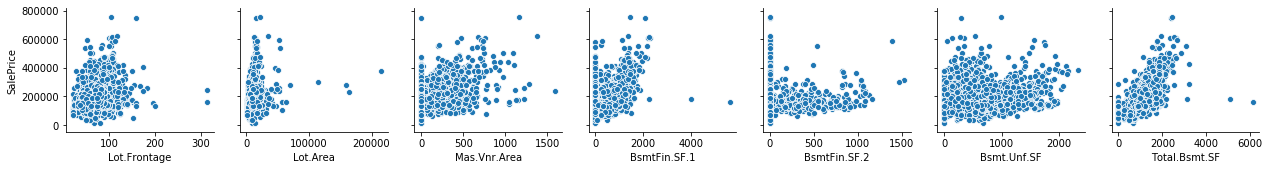

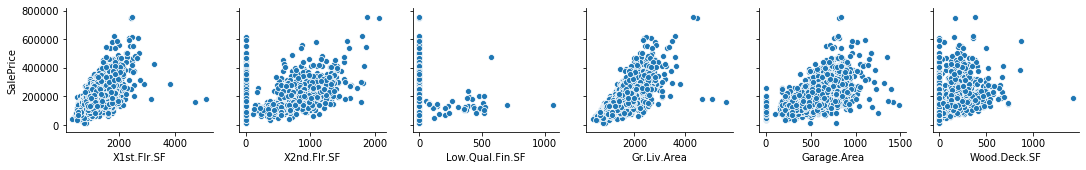

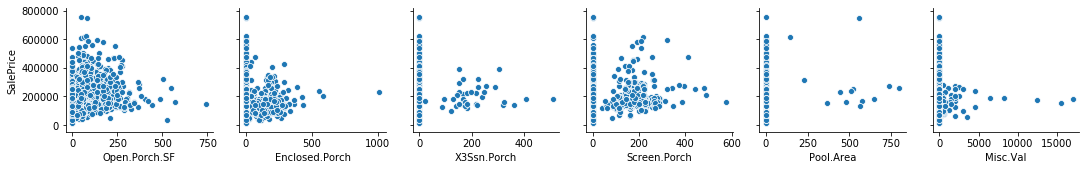

In [17]:
sns.pairplot(df_housing, y_vars=response_var, x_vars=numeric_vars[0:7])
sns.pairplot(df_housing, y_vars=response_var, x_vars=numeric_vars[7:13])
sns.pairplot(df_housing, y_vars=response_var, x_vars=numeric_vars[13:19])

Now we create boxplots of SalesPrice according to the categories given by the categorical variables.

To better visualize this, we first encode each categorical variable by ordering its distinct category values according to the mean of SalePrice calculated for each category value.

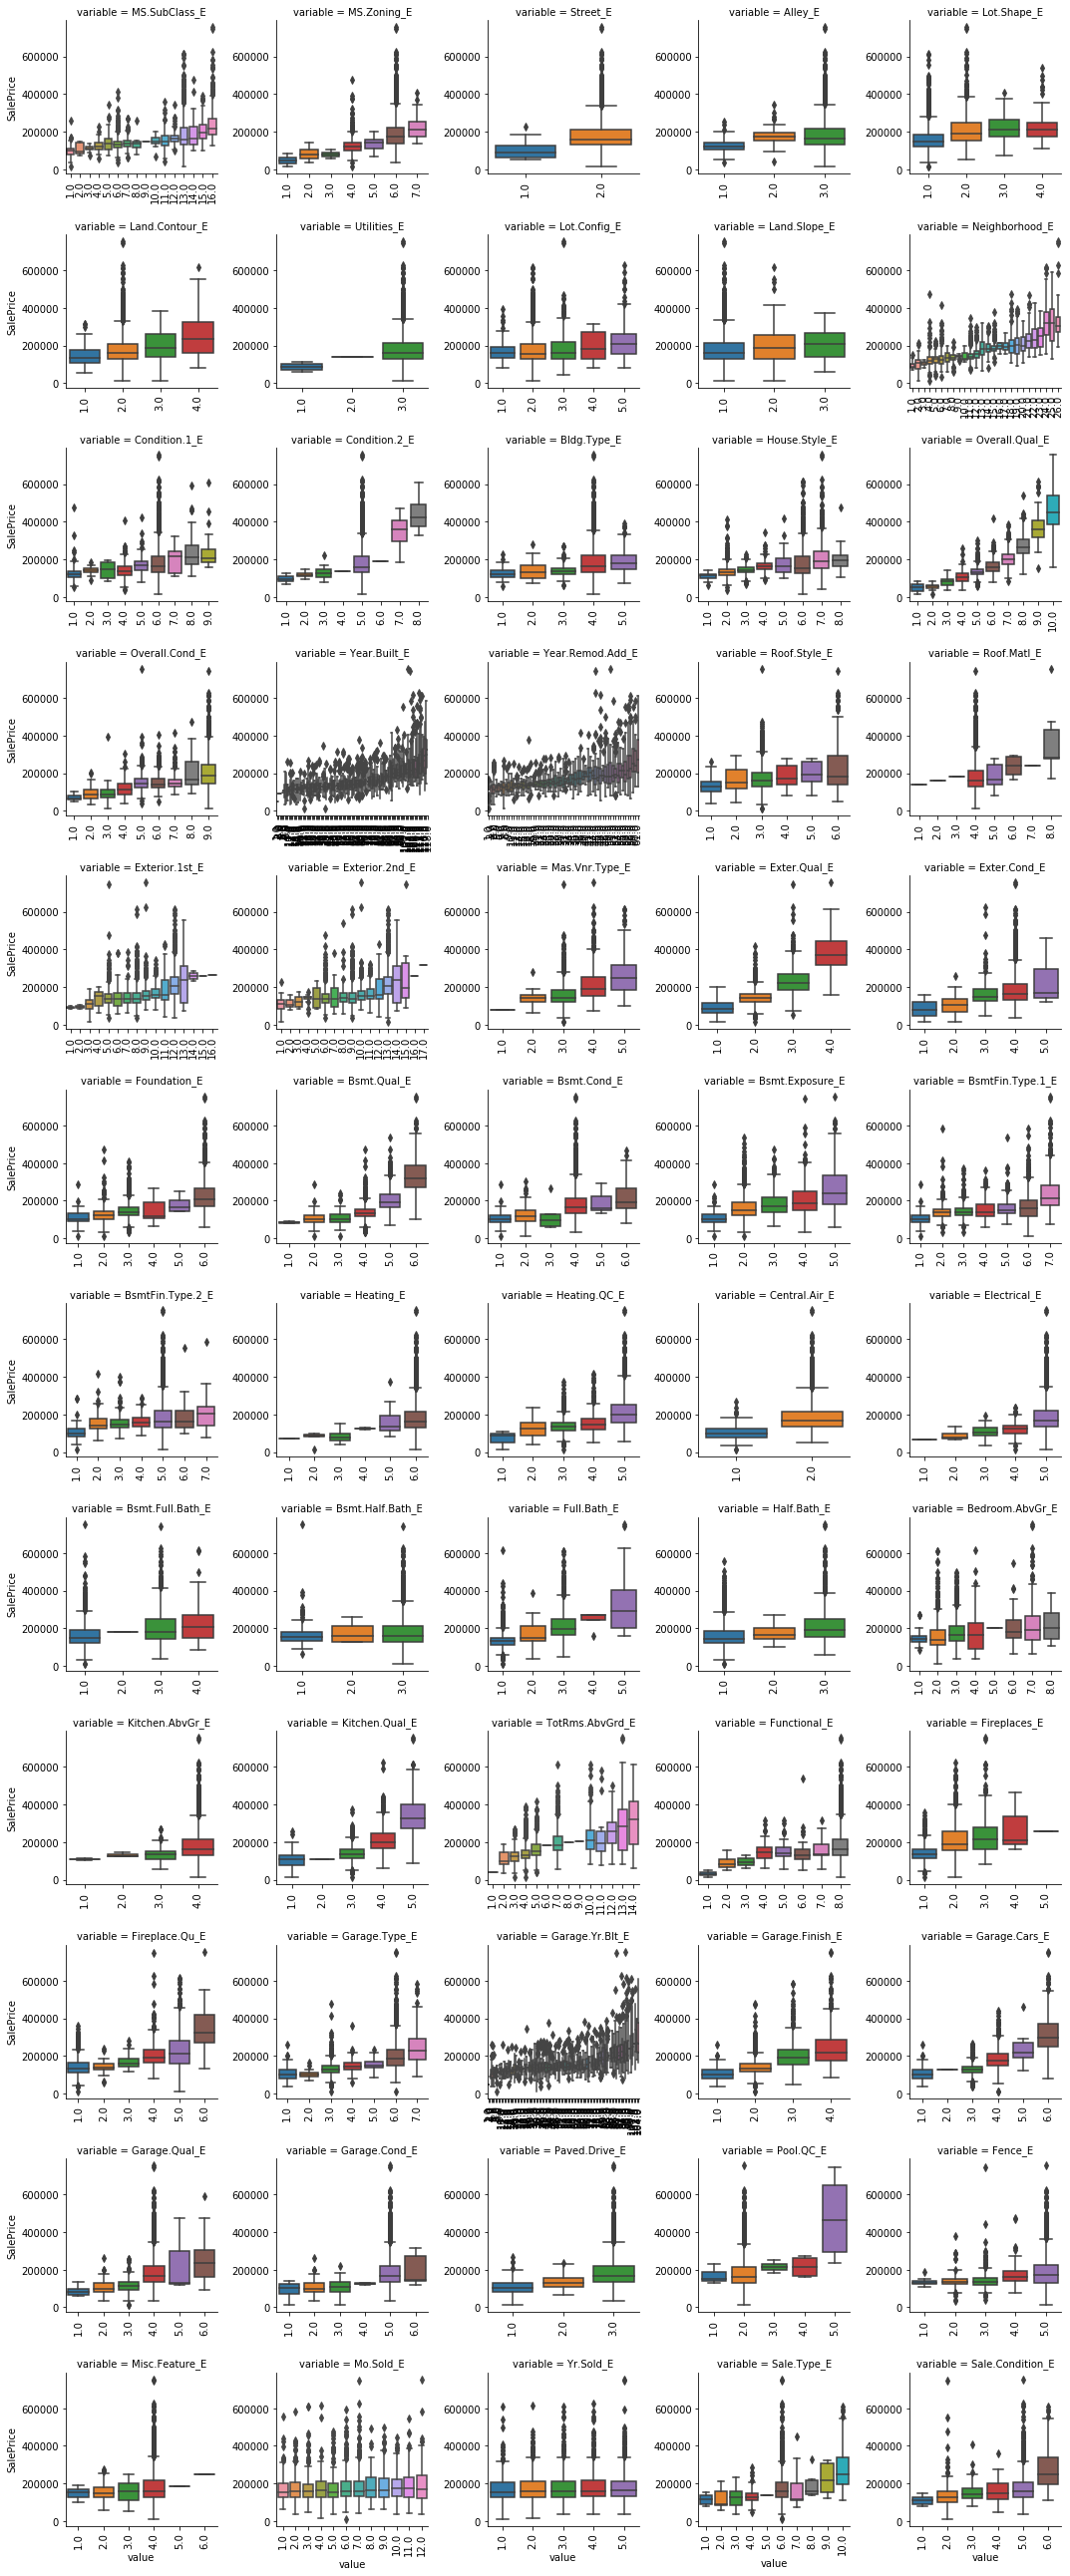

In [18]:
def encode(frame, feature):
    ordering = pd.DataFrame()
    ordering['val'] = frame[feature].unique()
    ordering.index = ordering.val
    ordering['spmean'] = frame[[feature, 'SalePrice']].groupby(feature).mean()['SalePrice']
    ordering = ordering.sort_values('spmean')
    ordering['ordering'] = range(1, ordering.shape[0]+1)
    ordering = ordering['ordering'].to_dict()
    
    for cat, o in ordering.items():
        frame.loc[frame[feature] == cat, feature+'_E'] = o
    
categorical_vars_E = []
for q in categorical_vars:  
    encode(df_housing, q)
    categorical_vars_E.append(q+'_E')

def boxplot(x, y, **kwargs):
    sns.boxplot(x=x, y=y)
    x=plt.xticks(rotation=90)

data = pd.melt(df_housing, id_vars=["SalePrice"], value_vars=categorical_vars_E)
g = sns.FacetGrid(data, col="variable",  col_wrap=5, sharex=False, sharey=False)
g = g.map(boxplot, "value", "SalePrice")

Here we plot the Spearman Correlation between `SalePrice` and each variable.

For this to make sense for the categorical variables, we use the previous numeric ordered encoded values to represent each of them.

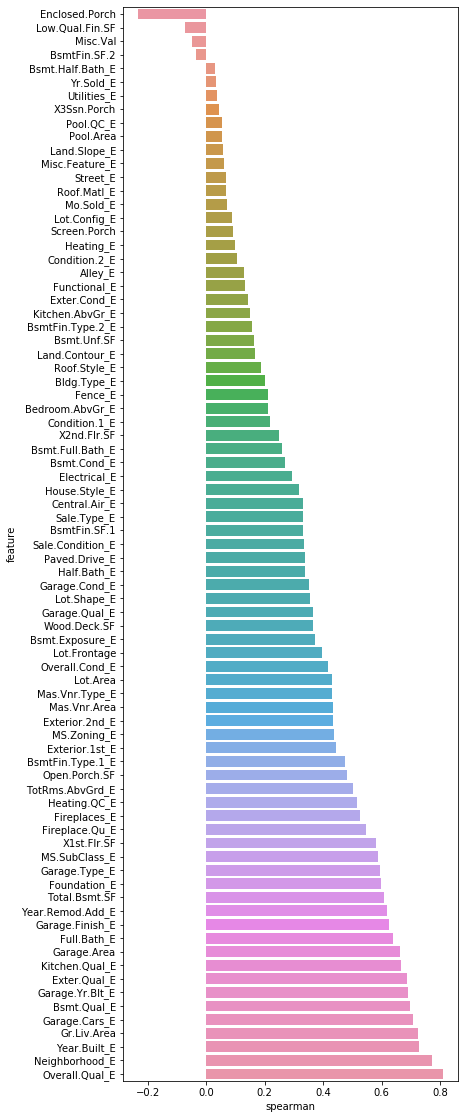

In [19]:
def spearman(frame, features):
    spr = pd.DataFrame()
    spr['feature'] = features
    spr['spearman'] = [frame[f].corr(frame['SalePrice'], 'spearman') for f in features]
    spr = spr.sort_values('spearman')
    plt.figure(figsize=(6, 0.25*len(features)))
    sns.barplot(data=spr, y='feature', x='spearman', orient='h')
    
features = numeric_vars + categorical_vars_E
spearman(df_housing, features)

Now we visualize the distribution of `SalePrice`.

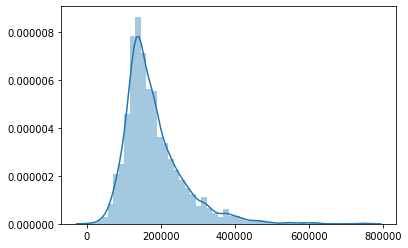

In [20]:
sns.distplot(df_housing[response_var])

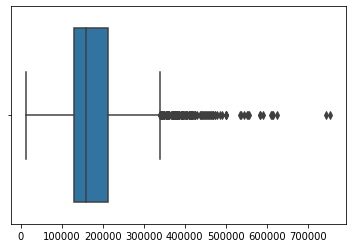

In [21]:
sns.boxplot(df_housing[response_var])

We are not going to perform any outlier analysis, feature selection or transformation here. Instead, we will try to model `SalePrice` directly using a non-linear regression algorithm.

As an example, we will use Gradient Boosting Regression.

The first step here is to split the dataset in a training portion and a test portion for final evaluation.

In [22]:
X_train, X_test, y_train, y_test = train_test_split(df_housing[numeric_vars + categorical_vars_E], df_housing[response_var],
                                                    test_size=0.4, random_state=0)

Now we create a loop for model training with grid search for hyperparameter selection and using the training data for 5-fold cross-validation.

In [23]:
parameter_grid = [{'n_estimators': [250,500,1000], 'max_depth': [4,8], 'min_samples_split': [2,4],
                   'learning_rate': [0.01], 'loss': ['ls']}]

scores = {'R2': make_scorer(r2_score), 'MAE': make_scorer(mean_absolute_error)}

cv_models = {}

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(GradientBoostingRegressor(), parameter_grid, cv=10, scoring=scores[score], n_jobs=-1)
    clf.fit(X_train, y_train)
    cv_models[score] = clf

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()
    


# Tuning hyper-parameters for R2

Best parameters set found on development set:

{'learning_rate': 0.01, 'loss': 'ls', 'max_depth': 4, 'min_samples_split': 2, 'n_estimators': 1000}

Grid scores on development set:

0.871 (+/-0.110) for {'learning_rate': 0.01, 'loss': 'ls', 'max_depth': 4, 'min_samples_split': 2, 'n_estimators': 250}
0.895 (+/-0.126) for {'learning_rate': 0.01, 'loss': 'ls', 'max_depth': 4, 'min_samples_split': 2, 'n_estimators': 500}
0.900 (+/-0.133) for {'learning_rate': 0.01, 'loss': 'ls', 'max_depth': 4, 'min_samples_split': 2, 'n_estimators': 1000}
0.872 (+/-0.107) for {'learning_rate': 0.01, 'loss': 'ls', 'max_depth': 4, 'min_samples_split': 4, 'n_estimators': 250}
0.896 (+/-0.124) for {'learning_rate': 0.01, 'loss': 'ls', 'max_depth': 4, 'min_samples_split': 4, 'n_estimators': 500}
0.899 (+/-0.135) for {'learning_rate': 0.01, 'loss': 'ls', 'max_depth': 4, 'min_samples_split': 4, 'n_estimators': 1000}
0.868 (+/-0.088) for {'learning_rate': 0.01, 'loss': 'ls', 'max

Get the best model and compute metrics for the test dataset.

In [24]:
best_model = cv_models['R2'].best_estimator_

mae = mean_absolute_error(y_test, best_model.predict(X_test))
print("MAE on test dataset: %.4f" % mae)

y_test_predicted = best_model.predict(X_test)
r2 = r2_score(y_test, y_test_predicted)
print("R2 on test dataset: %.4f" % r2)

MAE on test dataset: 14405.2127
R2 on test dataset: 0.9032


Compute relative feature importances using the best model.

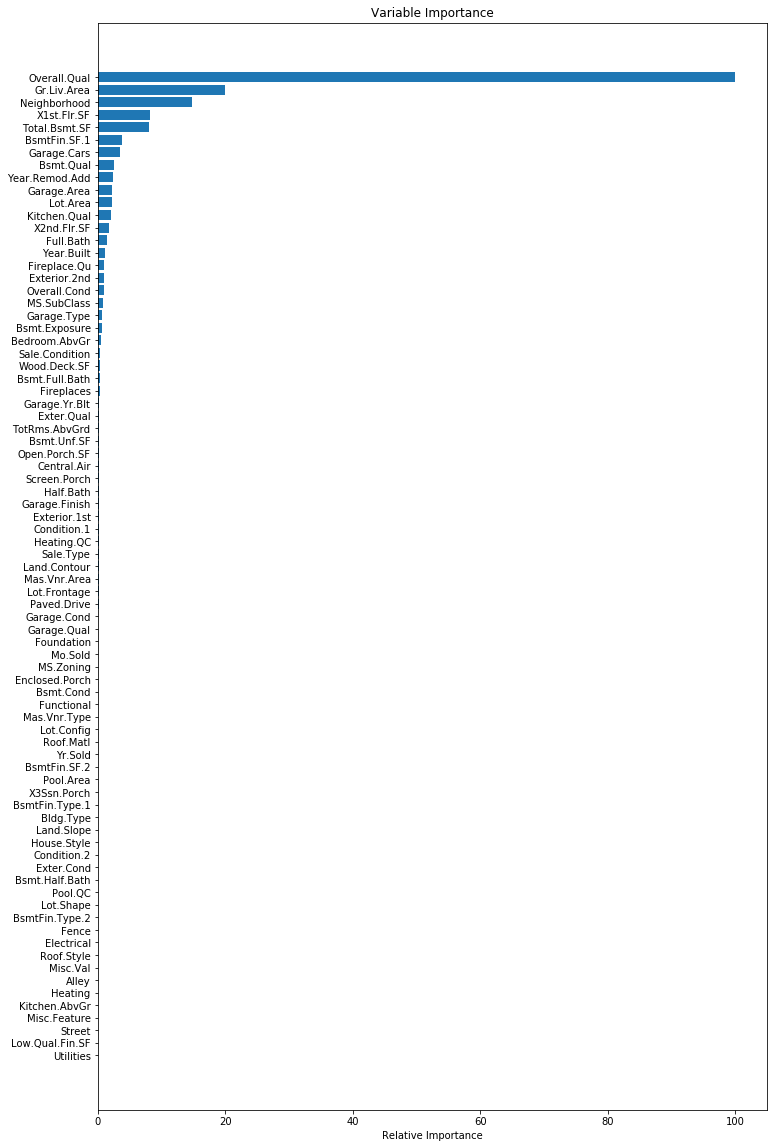

In [25]:
feature_importance = best_model.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())

sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
var_names = np.asarray(numeric_vars + categorical_vars)
fig = plt.figure(figsize=(12, 20))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, var_names[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [26]:
from sklearn.model_selection import cross_validate

scores = {'R2': make_scorer(r2_score), 'MAE': make_scorer(mean_absolute_error)}

clf = GradientBoostingRegressor(n_estimators=500, max_depth=4, min_samples_split=2, learning_rate=0.01, loss="ls")
scores = cross_validate(clf, X_train, y_train, scoring=scores, cv=5)

In [27]:
scores

{'fit_time': array([6.3583343 , 6.31262612, 6.31088758, 6.03061986, 6.43857551]),
 'score_time': array([0.02650046, 0.02322054, 0.02762604, 0.02018189, 0.02734351]),
 'test_R2': array([0.90859859, 0.92892602, 0.81518601, 0.9198912 , 0.92041314]),
 'train_R2': array([0.97457895, 0.97441262, 0.97589103, 0.97447852, 0.97494459]),
 'test_MAE': array([14663.57163607, 14816.81111909, 18229.97813113, 14919.40767991,
        14685.3387965 ]),
 'train_MAE': array([9699.42683959, 9577.21915491, 9481.20317967, 9777.12800386,
        9806.04709533])}

In [28]:
clf_fitted = clf.fit(X_train, y_train)
y_test_predicted = clf_fitted.predict(X_test)

mae = mean_absolute_error(y_test, y_test_predicted)
print("MAE on test dataset: %.4f" % mae)

r2 = r2_score(y_test, y_test_predicted)
print("R2 on test dataset: %.4f" % r2)

MAE on test dataset: 14842.7021
R2 on test dataset: 0.9012


In [29]:
scores["test_R2"].mean()

0.8986029892395436